# Gaussian process regression for cherry blossom season peak date

The data set for this notebook is a record of the date of peak cherry blossom flowering in Kyoto, Japan, compiled by Osaka University researchers and reported in several papers (Aono and Kazui, 2008; Aono and Saito, 2010; Aono, 2012).

In [1]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, arviz as az
import matplotlib.pyplot as plt
import time

In [2]:
tic = time.time()

In [3]:
df = pd.read_csv('../data/KyotoFullFlower.csv').dropna()  # Many years, especially early in history, don't have data
df

,AD,Full-flowering date (DOY),Full-flowering date,Source code,Data type code,Reference Name
11,812,92.0,401.0,1.0,2.0,NIHON-KOKI
14,815,105.0,415.0,1.0,2.0,NIHON-KOKI
30,831,96.0,406.0,1.0,2.0,NIHON-KOKI
50,851,108.0,418.0,1.0,2.0,MONTOKUTENNO-JITSUROKU
52,853,104.0,414.0,1.0,2.0,MONTOKUTENNO-JITSUROKU
...,...,...,...,...,...,...
1216,2017,99.0,409.0,8.0,0.0,NEWS-PAPER(ARASHIYAMA)
1217,2018,89.0,330.0,8.0,0.0,NEWS-PAPER(ARASHIYAMA)
1218,2019,95.0,405.0,8.0,0.0,NEWS-PAPER(ARASHIYAMA)
1219,2020,92.0,401.0,8.0,0.0,NEWS-PAPER(ARASHIYAMA)


For experimenting with MCMC sampling, it's useful to work with a reduced data set so that the models fit faster (MCMC sampling for GPs is computationally expensive when the data size is not small). For MAP estimation, the full data set is ok.

In [4]:
# Uncomment here to subsample for faster computation
# df = df.iloc[np.arange(0, 825, 3), :]

In [5]:
t = np.array(df['AD'])[:, None] # pm.gp functions require that the data be an Nx1 array, not a vector

### A simple model

Our first model, just to check practicality of the fit, will be a simple GP with only one component and squared-exponential covariance:
$$
\mathrm{cov}(x, y) = \eta^2 \exp\left(-\frac{|x - y|^2}{2\ell^2}\right)
$$
where $\eta$ is a scale parameter for the covariance, and $\ell$ a length scale. The prior on $\eta$ can be a simple HalfCauchy or Exponential. We'll explore a few different priors for the length scale.

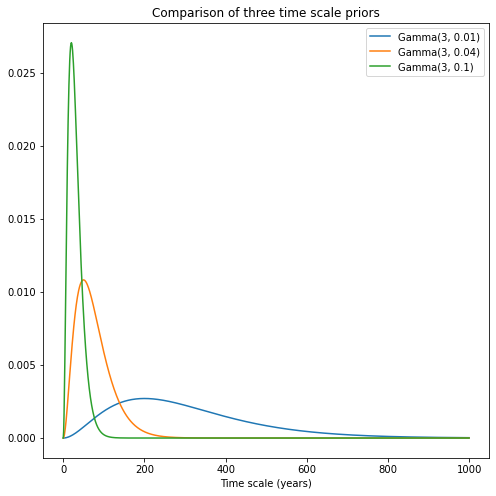

In [6]:
# Investigate the priors:
plt.figure(figsize=(8,8))
y1 = pm.Gamma.dist(3, 1/100).logp(np.arange(0, 1000)).eval()
y2 = pm.Gamma.dist(3, 1/25).logp(np.arange(0, 1000)).eval()
y3 = pm.Gamma.dist(3, 1/10).logp(np.arange(0, 1000)).eval()
plt.plot(np.arange(0, 1000), np.exp(y1), label = 'Gamma(3, 0.01)')
plt.plot(np.arange(0, 1000), np.exp(y2), label = 'Gamma(3, 0.04)')
plt.plot(np.arange(0, 1000), np.exp(y3), label = 'Gamma(3, 0.1)')
plt.legend()
plt.xlabel('Time scale (years)')
plt.title('Comparison of three time scale priors')
plt.show()

We try each prior, plugging into the model below:

$$
\begin{align*}
y_i &\sim \mathrm{Normal}(f(x_i), \sigma)\\
f &\sim \mathcal{GP}(0, K)\\
K(x_1, x_2) &= \eta^2 \exp\left(-\frac{|x_1 - x_2|^2}{2\ell^2}\right)\\
\eta &\sim \mathrm{HalfCauchy}(1)\\
\ell &\sim \mathrm{Gamma(3, \{0.01, 0.04, 0.10\})}\\
\end{align*}
$$

In [7]:
with pm.Model() as gp_model_slow:
    eta = pm.HalfCauchy('eta', 1)
    ls = pm.Gamma('ls', 3, 1/100)
    cov_func = (eta ** 2) * pm.gp.cov.ExpQuad(1, ls=ls)
    gp_fit = pm.gp.Marginal(cov_func=cov_func)
    
    sigma = pm.HalfCauchy('sigma', 1)
        
    y_ = gp_fit.marginal_likelihood('y', X=t, y=df['Full-flowering date (DOY)'].values, noise=sigma)
    
    map_est_slow = pm.find_MAP()
    #trace = pm.sample(500, tune = 500, return_inferencedata=True, init = 'advi')

In [8]:
newT = np.array(df.AD)[:, None]
mu_slow, var_slow = gp_fit.predict(newT, point = map_est_slow, diag = True)

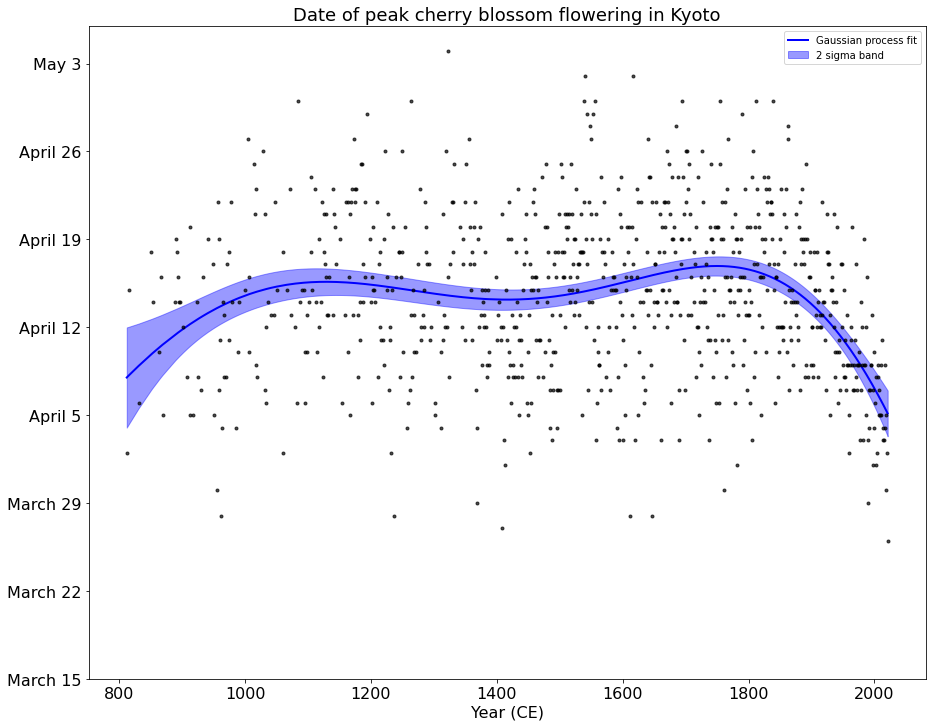

In [9]:
# Plot the GP fit
plt.figure(figsize=(15, 12))
plt.plot(newT, mu_slow, color = 'blue', lw=2, label = 'Gaussian process fit')
plt.plot(newT, df['Full-flowering date (DOY)'], '.', color = 'k', alpha = 0.7)
plt.fill_between(x=newT.flatten(), y1=mu_slow-2*np.sqrt(var_slow), y2=mu_slow+2*np.sqrt(var_slow), color = 'blue', alpha = 0.4, label = '2 sigma band')
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
dates = ['March 15', 'March 22', 'March 29', 'April 5', 'April 12', 'April 19', 'April 26', 'May 3']
plt.yticks(np.arange(74, 130, 7), labels = dates, size = 16)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend()
plt.show()

In [10]:
with pm.Model() as gp_model_med:
    eta = pm.HalfCauchy('eta', 1)
    ls = pm.Gamma('ls', 3, 1/25)
    cov_func = (eta ** 2) * pm.gp.cov.ExpQuad(1, ls=ls)
    gp_fit = pm.gp.Marginal(cov_func=cov_func)
    
    sigma = pm.HalfCauchy('sigma', 1)
        
    y_ = gp_fit.marginal_likelihood('y', X=t, y=df['Full-flowering date (DOY)'].values, noise=sigma)
    
    map_est_med = pm.find_MAP()
    #trace = pm.sample(500, tune = 500, return_inferencedata=True, init = 'advi')

In [11]:
newT = np.array(df.AD)[:, None]
mu_med, var_med = gp_fit.predict(newT, point = map_est_med, diag = True)

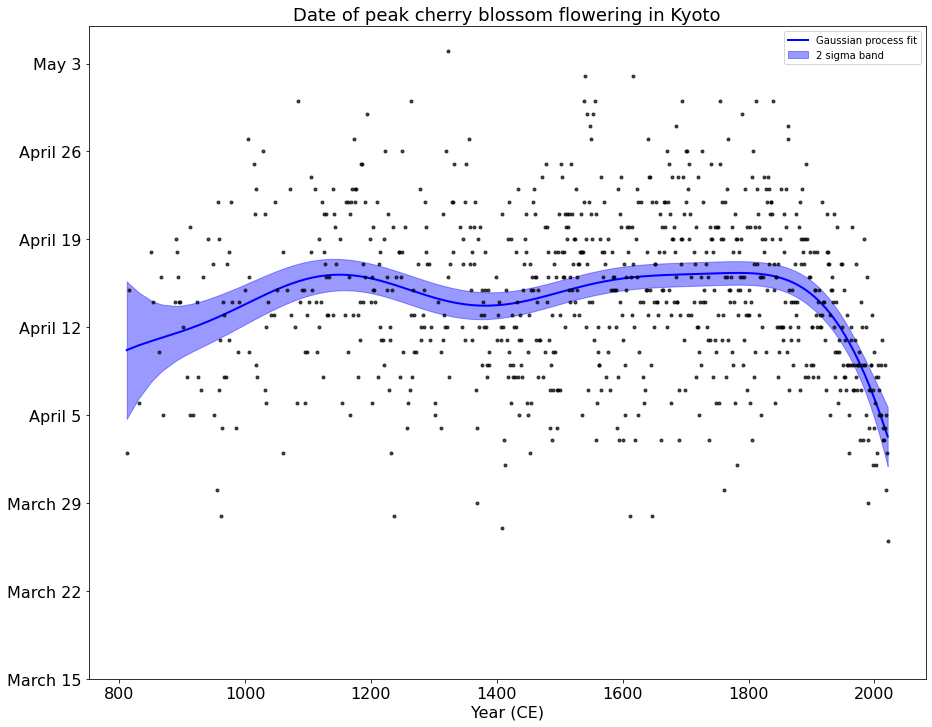

In [12]:
# Plot the GP fit
plt.figure(figsize=(15, 12))
plt.plot(newT, mu_med, color = 'blue', lw=2, label = 'Gaussian process fit')
plt.plot(newT, df['Full-flowering date (DOY)'], '.', color = 'k', alpha = 0.7)
plt.fill_between(x=newT.flatten(), y1=mu_med-2*np.sqrt(var_med), y2=mu_med+2*np.sqrt(var_med), color = 'blue', alpha = 0.4, label = '2 sigma band')
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
dates = ['March 15', 'March 22', 'March 29', 'April 5', 'April 12', 'April 19', 'April 26', 'May 3']
plt.yticks(np.arange(74, 130, 7), labels = dates, size = 16)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend()
plt.show()

In [13]:
with pm.Model() as gp_model_fast:
    # Priors for covariance parameters
    eta = pm.HalfCauchy('eta', 1)
    ls = pm.Gamma('ls', 3, 1/10)
    cov_func = (eta ** 2) * pm.gp.cov.ExpQuad(1, ls=ls)
    gp_fit = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy('sigma', 1)
        
    y_ = gp_fit.marginal_likelihood('y', X=t, y=df['Full-flowering date (DOY)'].values, noise=sigma)
    
    map_est_fast = pm.find_MAP()
    #trace = pm.sample(500, tune = 500, return_inferencedata=True, init = 'advi')

In [14]:
mu_fast, var_fast = gp_fit.predict(newT, point = map_est_fast, diag = True)

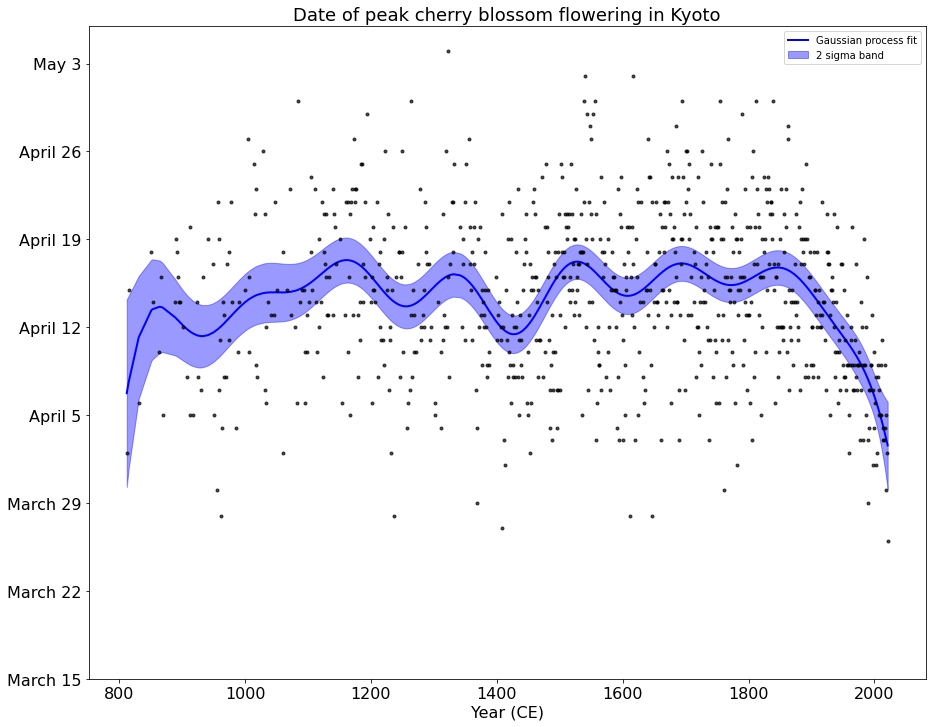

In [15]:
# Plot the GP fit
plt.figure(figsize=(15, 12))
plt.plot(newT, mu_fast, color = 'blue', lw=2, label = 'Gaussian process fit')
plt.plot(newT, df['Full-flowering date (DOY)'], '.', color = 'k', alpha = 0.7)
plt.fill_between(x=newT.flatten(), y1=mu_fast-2*np.sqrt(var_fast), y2=mu_fast+2*np.sqrt(var_fast), color = 'blue', alpha = 0.4, label = '2 sigma band')

# Formatting stuff
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
plt.yticks(np.arange(74, 130, 7), labels = dates, size = 16)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend()
plt.show()

This suggests variation on two scales: a slow trend, taking place over centuries, and a fast trend, which we model as a semi-periodic fluctuation around the slow trend.

In [16]:
with pm.Model() as gp_model_decomposed:
    # Priors for semi-periodic component
    eta_periodic = pm.HalfCauchy('eta_periodic', 1)
    l_periodic = pm.Gamma('l_periodic', 3, 1/10)
    l_periodic_decay = pm.Gamma('l_periodic_decay', 3, 1/50)
    period = pm.Exponential('period', 0.01)
    periodic_cov = (eta_periodic ** 2) * pm.gp.cov.Periodic(1, ls=l_periodic, period = period) * pm.gp.cov.Matern52(1, ls=l_periodic_decay)
    gp_periodic = pm.gp.Marginal(cov_func=periodic_cov)
      
    # Priors for slow trend
    eta_slow = pm.HalfCauchy('eta_slow', 2)
    l_slow = pm.Gamma('l_slow', 5, 1/100)
    slow_cov = (eta_slow ** 2) * pm.gp.cov.ExpQuad(1, ls=l_slow)
    gp_slow = pm.gp.Marginal(cov_func=slow_cov)
    
    # Combined model
    gp_full = gp_slow + gp_periodic
    sigma = pm.HalfCauchy('sigma', 1)
    
    y_ = gp_full.marginal_likelihood('y', X=t, y=df['Full-flowering date (DOY)'].values, noise=sigma)
    
    map_decomp = pm.find_MAP()
    #trace = pm.sample(250, tune = 250, return_inferencedata=True)

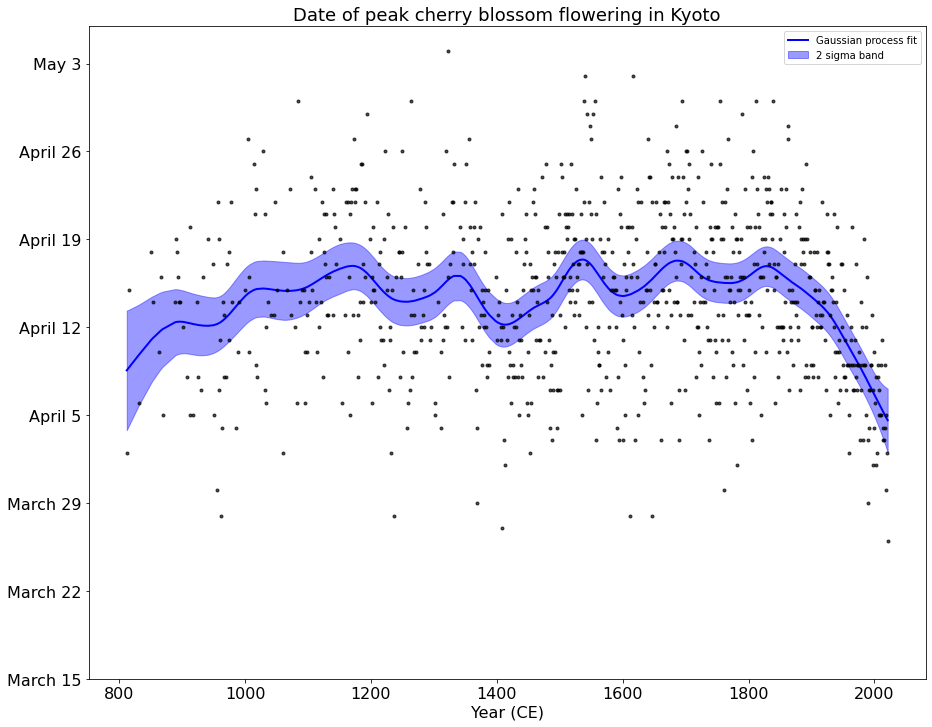

In [17]:
# Compute the fit
mu, var = gp_full.predict(newT, point=map_decomp, diag=True)

# Plot the fit, with uncertainty band
plt.figure(figsize=(15, 12))
plt.plot(newT, mu, color = 'blue', lw=2, label = 'Gaussian process fit')
plt.plot(newT, df['Full-flowering date (DOY)'], '.', color = 'k', alpha = 0.7)
plt.fill_between(x=newT.flatten(), y1=mu-2*np.sqrt(var), y2=mu+2*np.sqrt(var), color = 'blue', alpha = 0.4, label = '2 sigma band')

# Formatting stuff
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
dates = ['March 15', 'March 22', 'March 29', 'April 5', 'April 12', 'April 19', 'April 26', 'May 3']
plt.yticks(np.arange(74, 130, 7), labels = dates, size = 16)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend()
plt.show()

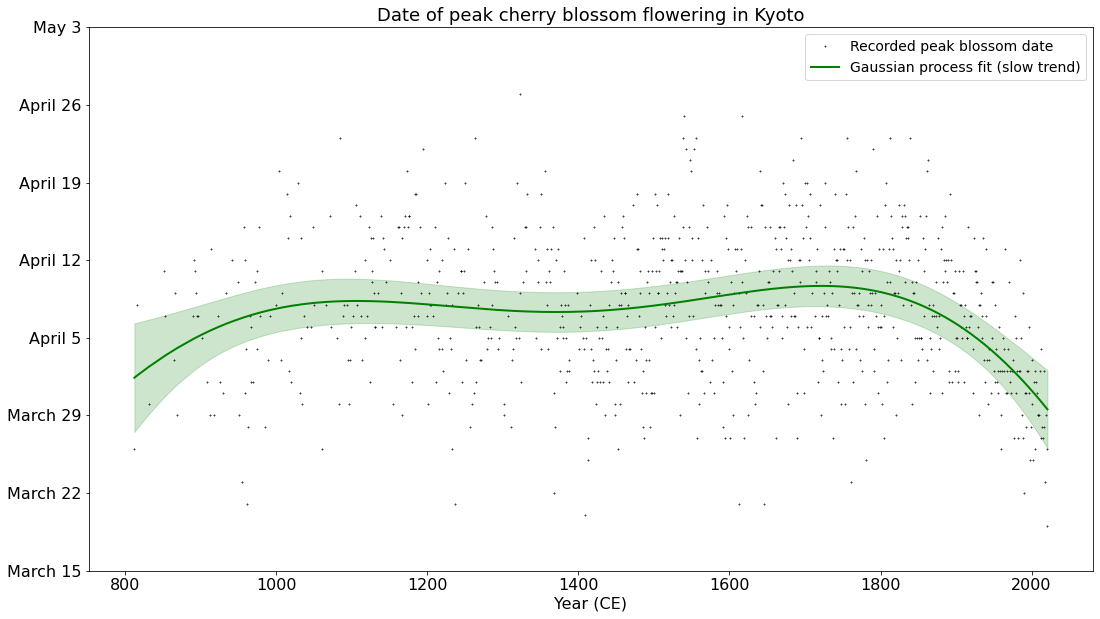

In [18]:
# Predicting with sub-components requires the `given` argument
mu_long, var_long = gp_slow.predict(newT, point=map_decomp, diag=True, given={"gp": gp_full, "X": newT, "y": df['Full-flowering date (DOY)'].values, "noise": sigma})
mu_fast, var_fast = gp_periodic.predict(newT, point=map_decomp, diag=True, given={"gp": gp_full, "X": newT, "y": df['Full-flowering date (DOY)'].values, "noise": sigma})

# Plot only slow fit
plt.figure(figsize=(18, 10))
plt.plot(newT, df['Full-flowering date (DOY)'], '+', markersize=2.5, color = 'k', alpha = 0.75, label = 'Recorded peak blossom date')
plt.plot(newT, mu_long, color = 'green', lw=2, ls='-', label = 'Gaussian process fit (slow trend)')
plt.fill_between(x=newT.flatten(), y1=mu_long-2*np.sqrt(var_long), y2=mu_long+2*np.sqrt(var_long), color = 'green', alpha = 0.2)

# Formatting stuff
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
plt.yticks(np.arange(81, 131, 7), labels = dates, size = 16)
plt.ylim(81, 130)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend(prop={'size':14})
plt.show()

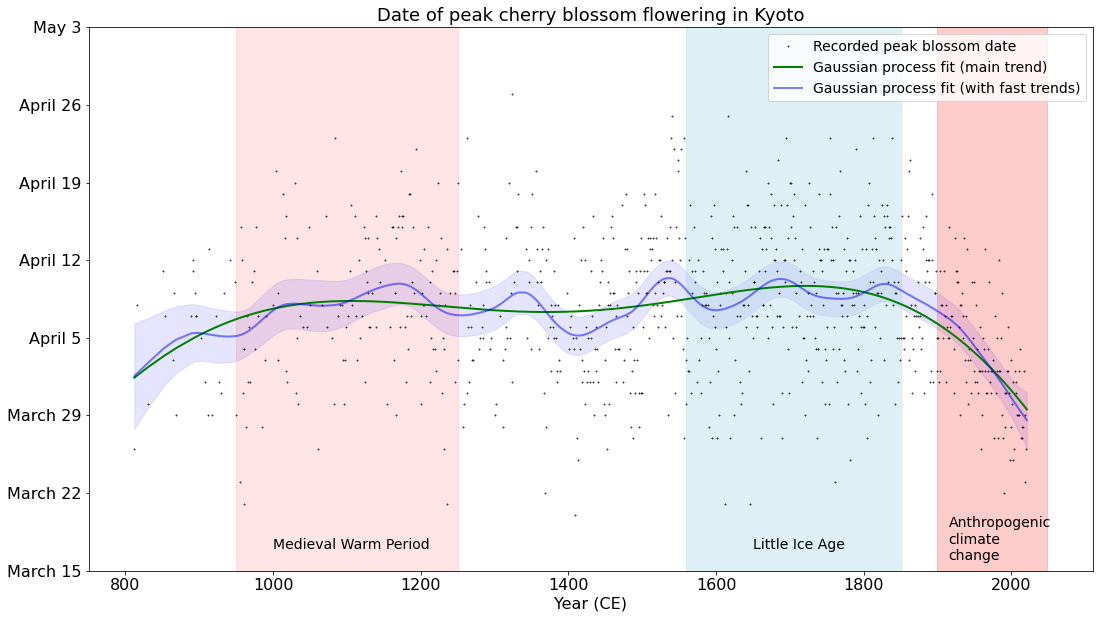

In [19]:
# Plot both fits
plt.figure(figsize=(18, 10))
plt.plot(newT, df['Full-flowering date (DOY)'], '+', markersize=2.5, color = 'k', alpha = 0.75, label = 'Recorded peak blossom date')
plt.plot(newT, mu_long, color = 'green', lw=2, ls='-', label = 'Gaussian process fit (main trend)')
plt.plot(newT, mu, color = 'blue', lw=2, ls = '-', alpha = 0.5, label = 'Gaussian process fit (with fast trends)')
plt.fill_between(x=newT.flatten(), y1=mu-2*np.sqrt(var), y2=mu+2*np.sqrt(var), color = 'blue', alpha = 0.1)

# Overlay some global climate events
plt.fill_between(x=np.arange(950,1251), y1=81*np.ones(301), y2=130*np.ones(301), color = 'red', alpha = 0.1)
plt.fill_between(x=np.arange(1560,1851), y1=81*np.ones(291), y2=130*np.ones(291), color = 'lightblue', alpha = 0.4)
plt.fill_between(x=np.arange(1900,2050), y1=81*np.ones(150), y2=130*np.ones(150), color = 'red', alpha = 0.2)
plt.text(x=1000, y=83, s='Medieval Warm Period', size=14)
plt.text(x=1650, y=83, s='Little Ice Age', size=14)
plt.text(x=1915, y=82, s='Anthropogenic\nclimate\nchange', size=14)

# Formatting stuff
plt.xlabel('Year (CE)', size=16)
plt.xticks(size=16)
plt.yticks(np.arange(81, 131, 7), labels = dates, size = 16)
plt.ylim(81, 130)
plt.title('Date of peak cherry blossom flowering in Kyoto', size = 18)
plt.legend(prop={'size':14})
plt.show()

In [20]:
toc = time.time()
print('Notebook ran in', round(toc - tic), 'seconds after imports.')
print('PyMC3 version', pm.__version__)
print('ArviZ version', az.__version__)

Notebook ran in 78 seconds after imports.
PyMC3 version 3.11.1
ArviZ version 0.11.2
